In [1]:
%matplotlib inline
%config Completer.use_jedi=False

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt

import lnPi
import lnPi.segment
import lnPi.stability
import lnPi.collectionlnpiutils

In [2]:
path = './ljmix4_full.t080.v512.r1.lnpi_o.dat.gz'
temp = 0.8
state_kws = {'temp': temp, 'beta' : 1.0 / temp, 'volume' : 512}
lnz =  np.array([-2.5, -2.5])

In [3]:
# delayed
ref = lnPi.MaskedlnPiDelayed.from_table(path, state_kws=state_kws, lnz=lnz).zeromax().pad()
phase_creator = lnPi.segment.PhaseCreator(nmax=2, nmax_peak=4, ref=ref, merge_kws=dict(efac=0.8))

# molfracs

In [4]:
df_mf = (
    pd.read_csv('./out.ljmix4_full.t080.v512.r1.lnpi_o.dat.const_mf.csv.gz')
    .assign(
        lnz_0=lambda x: x['beta'] * x['mu_0'],
        lnz_1=lambda x: x['beta'] * x['mu_1'],
        betaOmega=lambda x: -x['beta'] * x['pressure'] * x['volume']
    )
)    

In [5]:
import lnPi.molfrac

In [6]:
from joblib import Parallel, delayed
from tqdm import tqdm_notebook as tqdm

def get_stuff(lnz_0, mfs):
    x = np.linspace(-10., -1., 20)
    build_phases = phase_creator.build_phases_mu([lnz_0, None])
    c = lnPi.CollectionlnPi.from_builder(x, build_phases, unstack=True)
    
    L = []
    for mf in mfs:
        try:
            out, r = lnPi.molfrac.find_lnz_molfrac(mf, c, build_phases=build_phases, phase_id='None', component=1, 
                                                   ntry=20, dfac=1.5)
            L.append(out)
        except:
            pass
    return L

In [7]:
seq = df_mf.lnz_0.unique()
mfs = np.arange(0.05, 1.0, 0.05)

In [ ]:
with lnPi.set_options(tqdm_bar='text',tqdm_leave=True, joblib_use=False):
    L = Parallel(n_jobs=-1, backend='multiprocessing')(delayed(get_stuff)(lnz_0, mfs) for lnz_0 in tqdm(seq[:]))

/Users/wpk/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [474]:
LL = sum(L, [])

out = lnPi.CollectionlnPi.concat(LL)

In [512]:
table = (
    out.xge.table(['molfrac','mask_stable','betaOmega','dens'], default_keys=[], dim_to_suffix='component')
    .to_dataframe().dropna()#.query('mask_stable')
    .assign(mf_0=lambda x: np.round(x['molfrac_0'], 2))
    .assign(delta=lambda x: np.abs(x.mf_0 - x.molfrac_0))
    .reset_index()
)

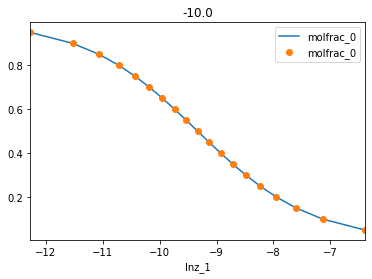

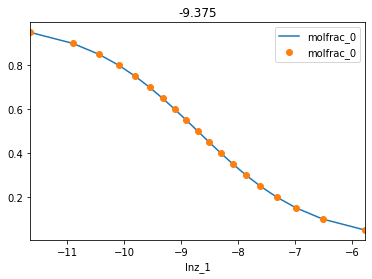

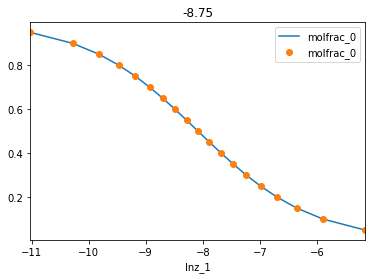

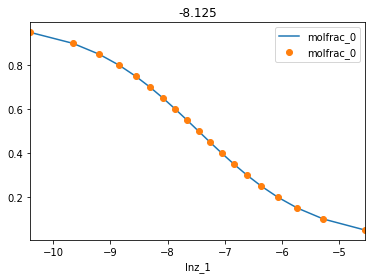

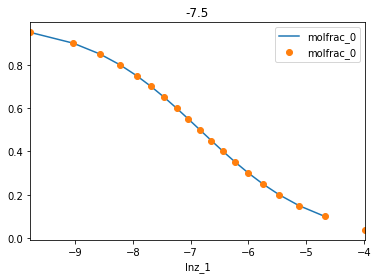

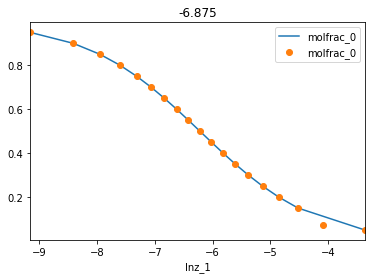

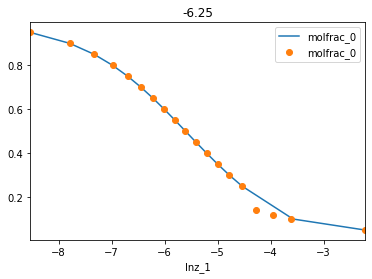

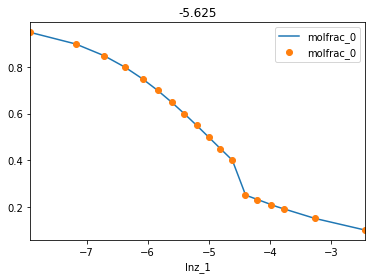

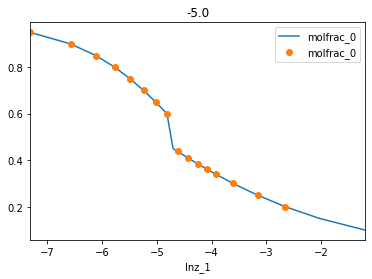

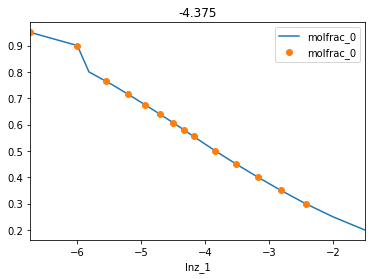

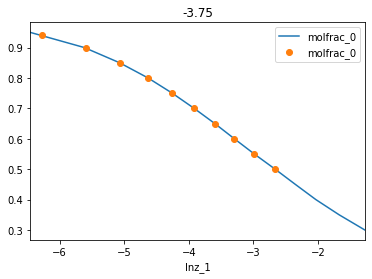

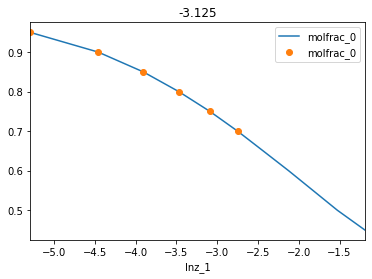

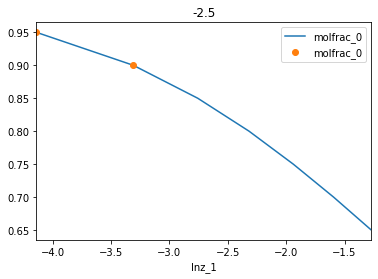

In [522]:
for lnz_0 in df_mf.lnz_0.unique()[::5]:
    fig, ax = plt.subplots()
    ax.set_title(lnz_0)
    table.query('mask_stable and lnz_0==@lnz_0').plot('lnz_1','molfrac_0', ax=ax)
    df_mf.query('lnz_0==@lnz_0').plot('lnz_1','molfrac_0', marker='o', ls='None', ax=ax)